In [1]:
import os
import shutil
import warnings

import numpy as np
import pandas as pd
import torchaudio

warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import json

import geopandas
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import soundfile
import tensorflow as tf
import torch

%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from torchaudio.transforms import MelSpectrogram
from tqdm import tqdm

In [2]:
SEED = 37
IMG_SIZE = 260
SAMPLE_RATE = 32000
N_FFT = 2048
SIGNAL_LENGTH = 5  # seconds
FREQ_MIN = 500
FREQ_MAX = 15000
MAX_AUDIO_FILES = 100
WIN_LENGHT = 128
AUDIO_PATH = "/app/_data/train_short_audio/"
JSON_PATH1 = "/app/_data/my/500_miles_monts.json"
JSON_PATH2 = "/app/_data/my/500_miles.json"

In [3]:
"XC579430.ogg", "XC590621.ogg" 

('XC579430.ogg', 'XC590621.ogg')

In [45]:
with open(JSON_PATH1, "r") as f:
    birds_500_m = json.load(f)

with open(JSON_PATH2, "r") as f:
    birds_500 = json.load(f)

In [46]:
# birds_500['total']

In [47]:
birds_500_m.keys()

dict_keys(['COL', 'COR', 'SNE', 'SSW', 'Total'])

In [3]:
# train_soundscape_labels = pd.read_csv("/app/_data/train_soundscape_labels_orig.csv")
# train_metadata = pd.read_csv("/app/_data/train_metadata_orig.csv")
# test = pd.read_csv("/app/_data/test.csv")
# test_dates = pd.read_csv("/app/_data/test_soundscapes/test_set_recording_dates.csv")

In [4]:
all_audio = pd.read_csv("/app/_data/all_audio_initial.csv")
# all_audio = all_audio[all_audio["primary_label"].str.len() <= 7]

In [6]:
# all_audio


In [55]:
all_audio_500 = all_audio.query('primary_label in @birds_500["total"] and secondary_labels in @birds_500["total"]')

In [57]:
all_audio_500.to_csv('/app/_data/my/all_audio_500.csv', index = False)

In [ ]:
# with open("/app/_data/dict_birds.json", "r") as d:
#     dict_birds = json.load(d)

# chunks

In [14]:
def my_floor(a, precision=2):
    dec = a - np.floor(a)
    dec = dec * 10 ** precision
    dec = np.floor(dec) / 10 ** precision
    b = np.floor(a) + dec
    return b

In [39]:
def make_segments(row, sig_lenght, ordered=True, rand=False):
    duration = row["duration"]
    max_num_intervals = int(duration // sig_lenght)
    if ordered:
        if max_num_intervals == 1:
            if duration >= 7:
                intervals = [
                    [0, sig_lenght],
                    [my_floor(duration - sig_lenght), my_floor(duration)],
                ]
            else:
                start = np.round((duration - sig_lenght) / 2, 2)
                intervals = [start, start + sig_lenght]
        elif max_num_intervals == 2:
            center = my_floor((duration - sig_lenght) / 2)
            intervals = [
                [0, sig_lenght],
                [my_floor(center), my_floor(center + sig_lenght)],
                [my_floor(duration - sig_lenght), my_floor(duration)],
            ]
        else:
            intervals = []
            for i in range(max_num_intervals):
                intervals.append([i * sig_lenght, (i + 1) * sig_lenght])
            if duration % sig_lenght >= 2:
                intervals.append([my_floor(duration - sig_lenght), my_floor(duration)])
    if rand:
        if max_num_intervals == 1:
            if duration >= 7:
                start1 = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                start2 = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                intervals = [
                    [start1, my_floor(start1 + sig_lenght)],
                    [start2, my_floor(start2 + sig_lenght)],
                ]
            elif 6 <= duration < 7:
                start = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                intervals = [my_floor(start), my_floor(start + sig_lenght)]
            elif duration < 6:
                start = np.round((duration - sig_lenght) / 2, 2)
                intervals = [start, start + sig_lenght]

        elif max_num_intervals == 2:
            intervals = []
            for i in range(3):
                start = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                intervals.append([my_floor(start), my_floor(start + sig_lenght)])
        else:
            intervals = []
            for i in range(max_num_intervals):
                start = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                intervals.append([my_floor(start), my_floor(start + sig_lenght)])
    new_row = row.copy()
    df = pd.DataFrame(columns=row1.index.tolist())
    if max_num_intervals == 1 and duration < 7:
        start = intervals[0]
        end = intervals[1]
        new_row["start_sec"] = start
        new_row["end_sec"] = end
        new_row["row_id"] = new_row["filename"] + "_" + "_".join(str(end).split("."))
        df.loc[0] = new_row
    else:
        for i in range(len(intervals)):
            start = intervals[i][0]
            end = intervals[i][1]
            new_row["start_sec"] = start
            new_row["end_sec"] = end
            new_row["row_id"] = (
                new_row["filename"] + "_" + "_".join(str(end).split("."))
            )
            df.loc[i] = new_row

    return df

In [7]:
def make_segments(row, sig_lenght, ordered=True, rand=False):
    duration = row[1]
    max_num_intervals = int(duration // sig_lenght)
    dict_intervals = []
    if ordered:
        if max_num_intervals == 1:
            if duration >= 7:
                intervals = [
                    [0, sig_lenght],
                    [my_floor(duration - sig_lenght), my_floor(duration)],
                ]
            else:
                start = np.round((duration - sig_lenght) / 2, 2)
                intervals = [start, start + sig_lenght]
        elif max_num_intervals == 2:
            center = my_floor((duration - sig_lenght) / 2)
            intervals = [
                [0, sig_lenght],
                [my_floor(center), my_floor(center + sig_lenght)],
                [my_floor(duration - sig_lenght), my_floor(duration)],
            ]
        else:
            intervals = []
            for i in range(max_num_intervals):
                intervals.append([i * sig_lenght, (i + 1) * sig_lenght])
            if duration % sig_lenght >= 2:
                intervals.append([my_floor(duration - sig_lenght), my_floor(duration)])
    if rand:
        if max_num_intervals == 1:
            if duration >= 7:
                start1 = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                start2 = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                intervals = [
                    [start1, my_floor(start1 + sig_lenght)],
                    [start2, my_floor(start2 + sig_lenght)],
                ]
            elif 6 <= duration < 7:
                start = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                intervals = [my_floor(start), my_floor(start + sig_lenght)]
            elif duration < 6:
                start = np.round((duration - sig_lenght) / 2, 2)
                intervals = [start, start + sig_lenght]

        elif max_num_intervals == 2:
            intervals = []
            for i in range(3):
                start = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                intervals.append([my_floor(start), my_floor(start + sig_lenght)])
        else:
            intervals = []
            for i in range(max_num_intervals):
                start = my_floor(
                    np.random.randint(0, np.floor(duration - sig_lenght))
                    + np.random.rand()
                )
                intervals.append([my_floor(start), my_floor(start + sig_lenght)])
    #     dict_intervals[0] = row[0]
    #     dict_intervals[1] = intervals
    #     dict_intervals[row[0]] = intervals
    intervals.append(row[0])
    if max_num_intervals == 1 and duration < 7:
        start = intervals[0]
        end = intervals[1]
    else:
        for i in range(len(intervals)):
            start = intervals[i][0]
            end = intervals[i][1]

    return intervals

In [8]:
short_audio_df = all_audio[
    ~all_audio["file_path"].str.contains("train_soundscapes")
].reset_index(drop=True)

In [9]:
short_audio_df.index = short_audio_df["filename"]

In [10]:
array_for_cut = short_audio_df[["filename", "duration"]].values

In [18]:
array_for_cut

array([['XC109605.ogg', 63.6745625],
       ['XC11209.ogg', 16.65415625],
       ['XC127032.ogg', 47.1390625],
       ...,
       ['XC602701.ogg', 101.869],
       ['XC614733.ogg', 16.4190625],
       ['XC615888.ogg', 77.125]], dtype=object)

In [15]:
a = make_segments(array_for_cut[2], 5, ordered=False, rand=True)

In [16]:
a

[[34.79, 39.79],
 [12.15, 17.14],
 [0.93, 5.92],
 [23.1, 28.1],
 [23.98, 28.98],
 [28.08, 33.09],
 [2.06, 7.07],
 [36.67, 41.67],
 [36.36, 41.36],
 'XC127032.ogg']

In [17]:
np.array(a[:-1])

array([[34.79, 39.79],
       [12.15, 17.14],
       [ 0.93,  5.92],
       [23.1 , 28.1 ],
       [23.98, 28.98],
       [28.08, 33.09],
       [ 2.06,  7.07],
       [36.67, 41.67],
       [36.36, 41.36]])

In [93]:
d = {}
d[b[-1]] = np.array(b[:-1])
d[a[-1]] = np.array(a[:-1])

In [97]:
d["XC11209.ogg"].shape

(3, 2)

In [100]:
ord_cut = {}
for i in tqdm(range(len(array_for_cut))):
    row = array_for_cut[i]
    seg = make_segments(row, 5, ordered=True, rand=False)
    ord_cut[seg[-1]] = np.array(seg[:-1])

100%|██████████| 62874/62874 [00:03<00:00, 18821.16it/s]


In [119]:
ord_cut["XC454273.ogg"]

array([0.98, 5.98])

In [116]:
col = [
    "rating",
    "filename",
    "row_id",
    "class_weights",
    "start_sec",
    "end_sec",
]

In [117]:
short_audio_df1 = short_audio_df[col]

In [ ]:
df = pd.DataFrame(columns=col)
for key in tqdm(ord_cut):
    row = short_audio_df1.loc[key]
    #     print(key)
    for i in ord_cut[key]:
        try:
            start = i[0]
            end = i[1]
        except:
            start = i
            end = 1 + 5
        filename = key.split(".")[0] + "_" + "_".join(str(end).split("."))
        row["start_sec"] = start
        row["end_sec"] = end
        row["row_id"] = filename
        df.loc[filename] = row

 56%|█████▋    | 35461/62874 [6:25:35<15:30:42,  2.04s/it] 

In [126]:
aa = {"a": {"b": 1, "c": 2}}

In [134]:
aa["a"]["b"] = [1, 3]

In [135]:
df

{'a': {'b': [1, 3], 'c': 2}}

In [136]:
dict_ordered = {}
for key in tqdm(ord_cut):
    for i in ord_cut[key]:
        try:
            start = i[0]
            end = i[1]
        except:
            start = i
            end = 1 + 5
        filename = key.split(".")[0] + "_" + "_".join(str(end).split("."))
        dict_ordered[key] = filename
        dict_ordered[key][filename] = [start, end]

  0%|          | 0/62874 [00:00<?, ?it/s]


TypeError: 'str' object does not support item assignment

In [46]:
random_cut = pd.DataFrame(columns=all_audio.columns)
for i in tqdm(range(len(short_audio_df))):
    row = short_audio_df.loc[i]
    #     print(i)
    df = make_segments(row, 5, ordered=False, rand=True)
    random_cut = pd.concat([random_cut, df], axis=0, ignore_index=True)

100%|██████████| 62874/62874 [7:54:15<00:00,  2.21it/s]   


In [47]:
random_cut.to_csv("/app/_data/random_cut1.csv", index=False)

In [49]:
for i in tqdm(range(len(short_audio_df))):
    row = short_audio_df.loc[i]
    #     print(i)
    df = make_segments(row, 5, ordered=True, rand=False)
    ordered_cut = pd.concat([ordered_cut, df], axis=0, ignore_index=True)

  0%|          | 155/62874 [00:28<3:13:47,  5.39it/s]


KeyboardInterrupt: 

In [ ]:
ordered_cut.to_csv("/app/_data/ordered_cut1.csv", index=False)

In [121]:
random_cut_sample = random_cut.sample(
    n=40000, weights="class_weights", random_state=SEED
)

<AxesSubplot:>

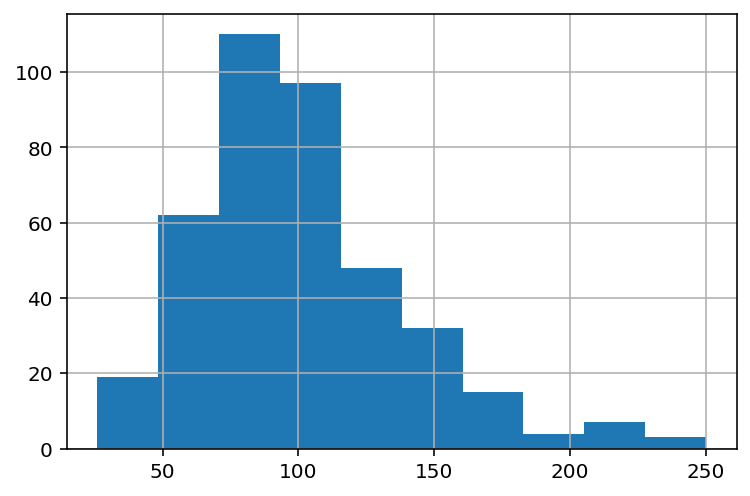

In [124]:
random_cut_sample["label_id"].value_counts().hist()

<AxesSubplot:>

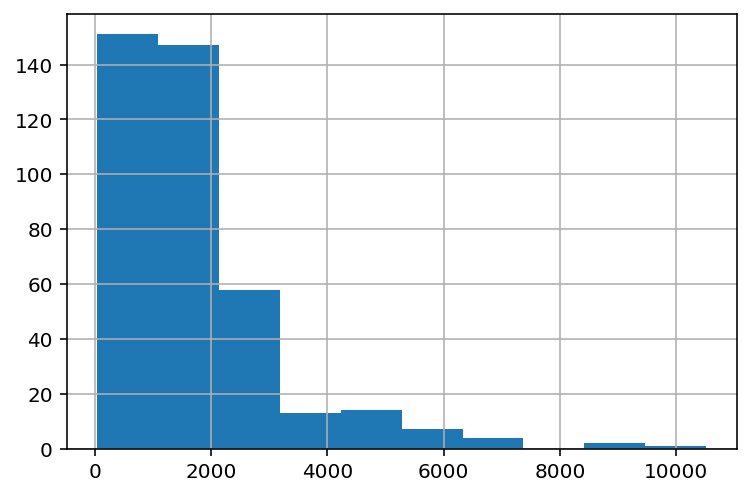

In [125]:
random_cut["label_id"].value_counts().hist()

In [ ]:
# s = all_audio["primary_label"].value_counts()
# s.describe()

# fig = go.Figure(
#     data=[go.Bar(y=s.values, x=s.index)],
#     layout=go.Layout(margin=go.layout.Margin(l=0, r=0, b=10, t=50)),
# )

# fig.show()

# s1 = all_audio_sample["primary_label"].value_counts()
# s1.describe()

# all_audio_sample['label_id'].hist(bins=399, figsize=(15, 10))
# fig = go.Figure(
#     data=[go.Bar(y=s.values, x=s.index)],
#     layout=go.Layout(margin=go.layout.Margin(l=0, r=0, b=10, t=50)),
# )

# fig.show()

In [5]:
def my_floor(a, precision=2):
    dec = a - np.floor(a)
    dec = dec * 10 ** precision
    dec = np.floor(dec) / 10 ** precision
    b = np.floor(a) + dec
    return b

In [15]:
def make_intervals(array, sig_lenght=5):
    dict_intervals = {}

    for row in array:
        duration = row[1]
        filename = row[0]
        weight = row[2]
        if duration <= 10:
            step=0.3
        elif 10<duration<=20:
            step = 1
        elif 20<duration<=40:
            step = 1.5
        else:
            step = 2
        for i in np.arange(0, duration+1, step):
            start = i
            end=i+sig_lenght
            if end <= duration:
                row_id = filename[:-4]+'_'+"_".join(str(end).split("."))
                dict_intervals[row_id] = [end, filename]
            else:
                end = my_floor(duration - np.random.rand())
                row_id = filename[:-4]+'_'+"_".join(str(end).split("."))
            dict_intervals[row_id] = [end,weight, filename]
    birds_intervals = pd.DataFrame(dict_intervals).T
    birds_intervals.columns = ['end_sec', 'class_weight', 'filename']
    return birds_intervals, dict_intervals


In [6]:
short_audio_df = all_audio[
    ~all_audio["file_path"].str.contains("train_soundscapes")
].reset_index(drop=True)

In [9]:
short_audio_df.index = short_audio_df["filename"]

In [8]:
short_audio_df.columns

Index(['primary_label', 'secondary_labels', 'latitude', 'longitude', 'date',
       'filename', 'rating', 'month', 'year', 'file_path', 'frames',
       'duration', 'row_id', 'sin_month', 'cos_month', 'sin_longitude',
       'cos_longitude', 'norm_latitude', 'label_id', 'class_weights',
       'num_intervals', 'start_sec', 'end_sec', 'secondary_labels_id'],
      dtype='object')

In [9]:
array_for_cut = short_audio_df[["filename", "duration", 'class_weights']].values

In [13]:
type(array_for_cut[0][2])

float

In [16]:
# for row in array_for_cut[:5]:
birds_intervals, dict_intervals = make_intervals(array_for_cut[:10], 5)

In [53]:
birds_intervals = pd.DataFrame(d_i).T

In [17]:
birds_intervals.head()

,end_sec,class_weight,filename
XC109605_5_0,5.0,0.007576,XC109605.ogg
XC109605_7_0,7.0,0.007576,XC109605.ogg
XC109605_9_0,9.0,0.007576,XC109605.ogg
XC109605_11_0,11.0,0.007576,XC109605.ogg
XC109605_13_0,13.0,0.007576,XC109605.ogg


In [18]:
birds_intervals['end_sec']

XC109605_5_0        5.0
XC109605_7_0        7.0
XC109605_9_0        9.0
XC109605_11_0      11.0
XC109605_13_0      13.0
                  ...  
XC131193_41_0      41.0
XC131193_43_0      43.0
XC131193_43_42    43.42
XC131193_43_17    43.17
XC131193_43_41    43.41
Name: end_sec, Length: 244, dtype: object

In [22]:
type(dict_intervals['XC109605_45_0'][0])

numpy.float64

In [23]:
dict_intervals['XC109605_45_0']

[45.0, 0.0075757575757575, 'XC109605.ogg']

In [26]:
pd.DataFrame(dict_intervals).T[1]

XC109605_5_0      0.007576
XC109605_7_0      0.007576
XC109605_9_0      0.007576
XC109605_11_0     0.007576
XC109605_13_0     0.007576
                    ...   
XC131193_41_0     0.007576
XC131193_43_0     0.007576
XC131193_43_42    0.007576
XC131193_43_17    0.007576
XC131193_43_41    0.007576
Name: 1, Length: 244, dtype: object

In [27]:
9851872 >11788574

False